## Querying Total Evapotranspiration from  OzWALD hosted by NCI via OpenDAP

This example shows how to query the Total Evapotranspiration from OpenDAP 
http://dap.nci.org.au/thredds/remoteCatalogService?catalog=http://dapds00.nci.org.au/thredds/catalog/ub8/au/OzWALD/daily/catalog.xml

The notebook provides widget interfaces for users to interact with. It then shows users how to perform various operations with xarray and then plot it using matplotlib - including locating the nearest grid to the selected city, and slicing the data by time.


In [46]:
!pip install xarray netCDF4 geopy


## Setup widgets to select city and year

In [47]:
#setup widgets
import ipywidgets as widgets
w = widgets.Dropdown(
    options=['Melbourne', 'Sydney', 'Canberra', 'Brisbane', 'Adelaide', 'Hobart', 'Perth', 'Darwin'],
    description='Capital city:',
    disabled=False,
)
arrYears = [str(i) for i in range(2000,2017)]
wYear = widgets.SelectionSlider(
    options=arrYears,
    value=arrYears[-1],
    description='Select year:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

In [48]:
w

Dropdown(description='Capital city:', options=('Melbourne', 'Sydney', 'Canberra', 'Brisbane', 'Adelaide', 'Hob…

In [49]:
wYear

SelectionSlider(continuous_update=False, description='Select year:', index=16, options=('2000', '2001', '2002'…

In [50]:
year = wYear.value

## Setup xarray

In [51]:
import xarray as xr


max_day_etot = "http://dapds00.nci.org.au/thredds/dodsC/ub8/au/OzWALD/daily/OzWALD.daily.ETtot.{}.nc".format(year)
max_day_etot

'http://dapds00.nci.org.au/thredds/dodsC/ub8/au/OzWALD/daily/OzWALD.daily.ETtot.2016.nc'

In [52]:
dataset = xr.open_dataset(max_day_etot)
dataset

<xarray.Dataset>
Dimensions:    (latitude: 681, longitude: 841, time: 366)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-12-31
  * longitude  (longitude) float32 112.0 112.05 112.1 ... 153.9 153.95 154.0
  * latitude   (latitude) float32 -10.0 -10.05 -10.1 ... -43.9 -43.95 -44.0
Data variables:
    ETtot      (time, longitude, latitude) float32 ...
Attributes:
    description:    These data are produced by the OzWALD model-data fusion s...
    creator_name:   Water and Landscape Dynamics group
    creator_url:    http://www.wenfo.org/wald/
    creator_email:  albert.vandijk@anu.edu.au
    institution:    Australian National University
    date_created:   12-Feb-2017
    ANU_license:    Creative Commons with Attribution (https://creativecommon...

In [53]:
dataset.ETtot


<xarray.DataArray 'ETtot' (time: 366, longitude: 841, latitude: 681)>
[209615886 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-12-31
  * longitude  (longitude) float32 112.0 112.05 112.1 ... 153.9 153.95 154.0
  * latitude   (latitude) float32 -10.0 -10.05 -10.1 ... -43.9 -43.95 -44.0
Attributes:
    short_name:   ETtot
    long_name:    Total evapotranspiration
    units:        mm/d
    _ChunkSizes:  [ 61 141 114]

## Use geopy to get the lat-long coordinates for the selected city

In [54]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="CSIRO widget")
location = geolocator.geocode("{},australia".format(w.value))
print((location.latitude, location.longitude))
print(location.raw)

(-37.8142176, 144.9631608)
{'place_id': '198386686', 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': '2404870', 'boundingbox': ['-37.85067', '-37.77545', '144.89709', '144.9913426'], 'lat': '-37.8142176', 'lon': '144.9631608', 'display_name': 'City of Melbourne, Victoria, Australia', 'class': 'boundary', 'type': 'administrative', 'importance': 0.923124610070791, 'icon': 'https://nominatim.openstreetmap.org/images/mapicons/poi_boundary_administrative.p.20.png'}


## Use city coordinates to find the nearest point in the grid for the data point

In [55]:
lon_st = location.longitude
lat_st = location.latitude

etot = dataset.ETtot.sel(longitude=lon_st, latitude=lat_st, method='nearest')
etot

<xarray.DataArray 'ETtot' (time: 366)>
array([ 1.359226,  1.453146,  1.300591, ...,  1.254174,  1.83606 ,  4.06912 ], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2016-12-31
    longitude  float32 144.95
    latitude   float32 -37.8
Attributes:
    short_name:   ETtot
    long_name:    Total evapotranspiration
    units:        mm/d
    _ChunkSizes:  [ 61 141 114]

## Plot using matplotlib

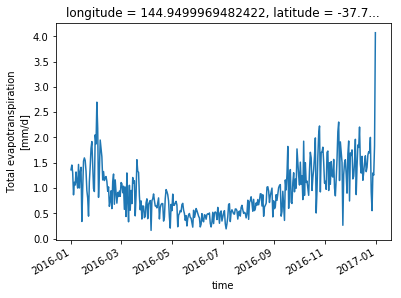

In [56]:
p = etot.plot()


## Use pandas to create a 6-month date range to filter the data for the dates selected

In [57]:
import pandas as pd

startdate = year + '-01-01'
enddate = year + '-06-30'

timerange = pd.date_range(startdate, enddate, freq='D')
timerange

DatetimeIndex(['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04',
               '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-09', '2016-01-10',
               ...
               '2016-06-21', '2016-06-22', '2016-06-23', '2016-06-24',
               '2016-06-25', '2016-06-26', '2016-06-27', '2016-06-28',
               '2016-06-29', '2016-06-30'],
              dtype='datetime64[ns]', length=182, freq='D')

In [58]:
six_month_ds = etot.sel({'time': timerange})

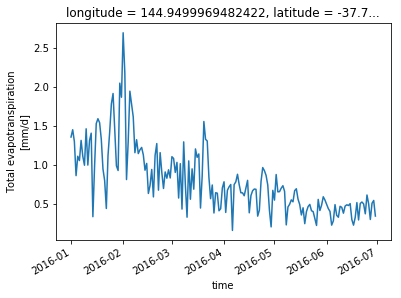

In [59]:
six_month_ds.plot()


## Compare Melbourne and Sydney

In [63]:
# get Melbourne coordinates
geolocator = Nominatim(user_agent="CSIRO widget")
mel_location = geolocator.geocode("Melbourne,australia".format(w.value))
etot_mel = dataset.ETtot.sel(longitude=mel_location.longitude, latitude=mel_location.latitude, method='nearest')

# get sydney coordinates and data
syd_location = geolocator.geocode("Sydney,australia".format(w.value))
etot_syd = dataset.ETtot.sel(longitude=syd_location.longitude, latitude=syd_location.latitude, method='nearest')

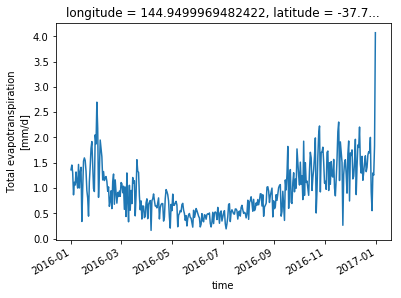

In [64]:
etot_mel.plot()

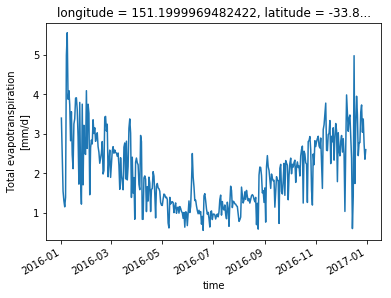

In [65]:
etot_syd.plot()